In [55]:
import os
from mat4py import loadmat
import h5py
import tables
import mat73
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from scipy import ndimage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_curve, auc

In [2]:
data1 = 'MRI_Tumor_Binary_Classification_Data/brainTumorDataPublic_1766/'
data2 = 'MRI_Tumor_Binary_Classification_Data/brainTumorDataPublic_7671532/'
data3 = 'MRI_Tumor_Binary_Classification_Data/brainTumorDataPublic_15332298/'
data4 = 'MRI_Tumor_Binary_Classification_Data/brainTumorDataPublic_22993064/'

In [37]:
# Read the data

patient_ids = []
images = []
labels = []
tumorBorders = []
tumorMask = []

def populate_lists(data1):
    for d in os.listdir(data1):
        mat = mat73.loadmat(data1 + d)
        patient_ids.append(mat['cjdata']['PID'])
        images.append(mat['cjdata']['image'])
        labels.append(int(mat['cjdata']['label']))
        tumorBorders.append(mat['cjdata']['tumorBorder'])
        tumorMask.append(mat['cjdata']['tumorMask'])
    return patient_ids, images, labels, tumorBorders, tumorMask

patient_ids, images, labels, tumorBorders, tumorMask = populate_lists(data1)
patient_ids, images, labels, tumorBorders, tumorMask = populate_lists(data2)
patient_ids, images, labels, tumorBorders, tumorMask = populate_lists(data3)
patient_ids, images, labels, tumorBorders, tumorMask = populate_lists(data4)

In [4]:
patient_ids[0]

'100360'

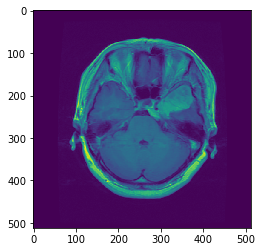

In [5]:
plt.imshow(images[0])

In [6]:
labels[0]

1

In [7]:
tumorBorders[0]

array([267.61524501, 231.37568058, 277.83666062, 248.10163339,
       289.91651543, 250.8892922 , 305.71324864, 253.676951  ,
       318.72232305, 249.9600726 , 321.50998185, 237.88021779,
       354.96188748, 234.16333938, 367.97096189, 227.65880218,
       380.9800363 , 210.93284936, 372.61705989, 195.13611615,
       363.32486388, 177.48094374, 350.31578947, 176.55172414,
       336.37749546, 183.98548094, 317.79310345, 196.06533575,
       305.71324864, 207.21597096, 295.49183303, 217.43738657,
       288.98729583, 222.08348457, 273.19056261, 223.94192377,
       268.54446461, 228.58802178])

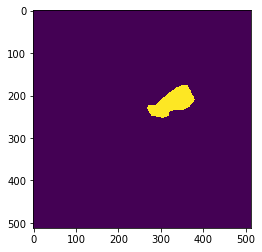

In [8]:
plt.imshow(tumorMask[0])

In [9]:
# Exploratory Analysis on Data

# Number of total samples
print('Number of total samples: ' + str(len(patient_ids)))

# Number of unique patients
print('Number of unique patients we have samples for: ' + str(len(set(patient_ids))))

# What are the unique class labels
print('Unique Class Labels: ' + str(set(labels)))

# Frequency of class labels
print('Frequency Class Labels: ' + str({x:labels.count(x) for x in labels}))
print('Class 1 is Meningioma, Class 2 is Glioma, Class 3 is Pituitary Tumor')

Number of total samples: 3064
Number of unique patients we have samples for: 233
Unique Class Labels: {1, 2, 3}
Frequency Class Labels: {1: 708, 2: 1426, 3: 930}
Class 1 is Meningioma, Class 2 is Glioma, Class 3 is Pituitary Tumor


In [10]:
# What do the individual tumors look like?

ind_1 = []
ind_2 = []
ind_3 = []

for ind in range(len(labels)):
    if labels[ind] == 1:
        ind_1.append(ind)
    elif labels[ind] == 2:
        ind_2.append(ind)
    else:
        ind_3.append(ind)

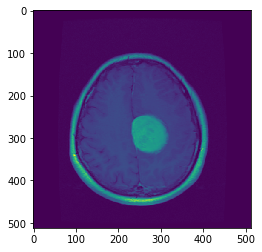

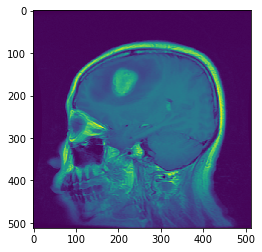

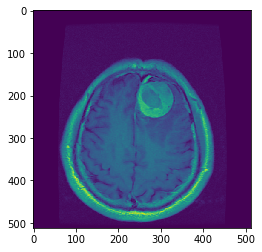

In [11]:
# Label 1 Samples

for i in random.sample(ind_1, 3):
    plt.figure()
    plt.imshow(images[i])

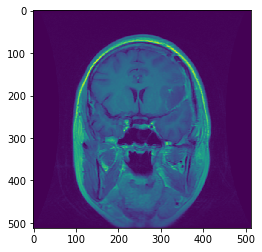

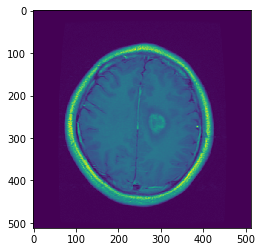

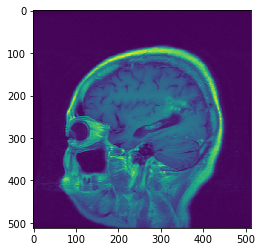

In [12]:
# Label 2 Samples

for i in random.sample(ind_2, 3):
    plt.figure()
    plt.imshow(images[i])

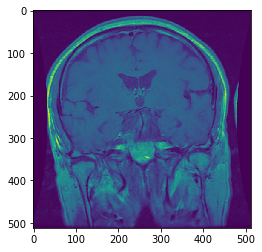

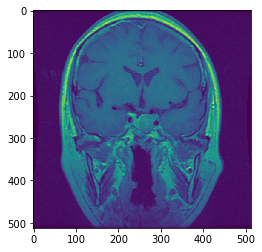

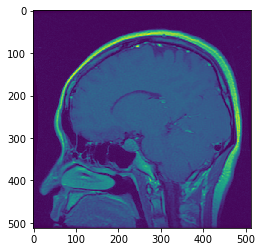

In [13]:
# Label 3 Samples

for i in random.sample(ind_3, 3):
    plt.figure()
    plt.imshow(images[i])

No identifiable differences between the tumor classes so we rely on the supervised model to classify these optimally.

In [14]:
# Length of the tumor border
for i in tumorBorders:
    print(len(i))
    
# We need to convert these borders to bounding boxes since the tumor borders are not uniform
bounding_boxes = []
for i in tumorMask:
    left_boundary = np.where(i.astype(int).sum(axis = 0) > 0)[0][0]
    right_boundary = np.where(i.astype(int).sum(axis = 0) > 0)[0][-1]
    top_boundary = np.where(i.astype(int).sum(axis = 1) > 0)[0][0]
    bottom_boundary = np.where(i.astype(int).sum(axis = 1) > 0)[0][-1]

38
26
42
40
54
34
66
52
52
56
52
46
30
42
26
76
38
40
64
62
80
44
30
38
70
60
56
64
106
42
52
34
84
50
48
52
46
60
64
58
44
116
108
48
52
46
50
48
44
46
38
56
64
50
94
80
38
54
50
42
34
60
78
68
68
88
86
38
48
50
56
24
50
62
70
54
54
50
22
76
80
98
92
84
46
66
66
74
52
50
50
80
64
56
38
46
26
56
80
62
30
60
62
58
58
114
94
78
90
42
72
64
50
42
48
38
34
84
90
76
82
78
64
62
106
94
84
102
88
94
64
50
52
42
40
50
64
70
54
76
88
66
56
56
54
44
40
82
66
62
68
60
68
64
54
38
38
52
48
48
60
58
50
42
46
50
54
62
50
38
34
32
48
60
60
46
68
40
34
38
40
46
40
70
50
42
56
42
42
52
60
40
50
38
36
50
78
64
58
74
36
64
54
48
38
50
34
30
46
42
46
64
56
68
68
64
50
56
42
46
48
96
58
52
98
104
110
82
72
66
100
66
72
66
76
62
48
52
48
52
24
48
44
32
36
46
42
52
46
40
34
32
40
56
60
44
62
60
44
48
44
50
44
44
50
36
34
28
30
64
38
42
38
82
86
86
60
32
32
36
40
38
40
42
54
64
40
50
58
52
52
78
70
70
62
76
46
40
40
44
48
42
48
58
86
78
60
56
84
84
40
54
54
46
52
68
70
92
130
70
78
78
44
34
48
38
26
28
62
84


22
28
38
28
26
32
36
22
48
42
48
36
32
40
44
60
82
34
62
48
56
82
42
22
26
40
22
24
22
32
36
62
78
76
66
26
36
26
26
24
42
22
16
14
30
24
22
34
28
18
24
22
24
26
18
14
28
26
28
46
46
56
30
40
34
20
36
32
34
44
40
38
26
22
22
16
14
24
26
22
30
38
40
34
22
20
36
40
54
46
42
36
16
18
20
38
26
32
44
40
40
34
26
24
16
22
48
44
24
54
30
34
34
36
20
30
36
32
20
26
28
32
28
32
20
16
20
24
26
38
30
30
20
14
24
22
24
28
26
30
30
30
26
32
22
20
30
38
36
28
30
26
28
34
40
36
36
44
60
76
52
40
32
24
32
32
20
30
36
30
34
36
30
18
34
30
32
34
32
42
38
38
38
44
54
32
30
24
48
28
44
26
22
20
18
28
28
24
28
32
28
22
40
44
44
48
58
74
80
68
56
54
22
28
30
28
20
72
44
40
48
48
48
12
30
34
30
34
40
48
20
26
30
36
38
44
64
64
32
38
28
30
30
36
34
26
42
20
38
34
42
60
58
64
56
20
28
24
16
24
44
38
34
58
80
52
28
32
38
34
50
50
54
56
66
32
38
60
42
58
42
22
10
16


In [15]:
np.where(tumorMask[0].astype(int).sum(axis = 0) > 0)[0]

array([267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279,
       280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292,
       293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305,
       306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318,
       319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331,
       332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344,
       345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357,
       358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370,
       371, 372, 373, 374, 375, 376, 377, 378, 379], dtype=int64)

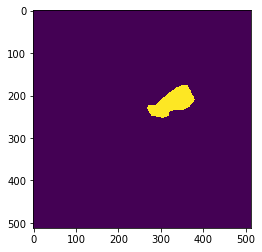

In [16]:
plt.imshow(tumorMask[0])

In [22]:
# Shape of images to ensure uniformity
shapes = []
for i in images:
    shapes.append(i.shape[0])

sum(shapes)/len(shapes)
# Not all are the same sizes

510.7467362924282

# Data Processing

In [38]:
# Resizing Images - we can use this as a hyperparameter but for now, let's construct 512x512 pixel images from those we have

width = 128
height = 128

resized_images = []

for i in images:
    resized_images.append(cv2.resize(i, (width, height), interpolation=cv2.INTER_LINEAR))

images = resized_images.copy()

In [39]:
# We can increase the number of samples by created denoised versions of the existing images using a Gaussian blur
# The tumor location does not change so we don't have to worry about fixing the border.

denoised_images = []

# We can use kernel shape as hyperparameter but for now, fixing to (11, 11)
denoising_kernel = (11, 11)

for i in images:
    denoised_images.append(cv2.GaussianBlur(i, denoising_kernel, 0))

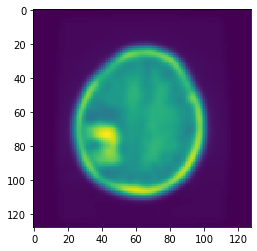

In [40]:
plt.imshow(denoised_images[10])

In [41]:
# We can further remove noise by segmenting the image using thresholding, with 128 as threshold. 
# But first, we should normalize the pixel values in each image from 0 to 255

seg_images = []

for i in denoised_images:
    temp = cv2.normalize(i, i, 0, 255, cv2.NORM_MINMAX)
    seg_images.append(cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY)[1])

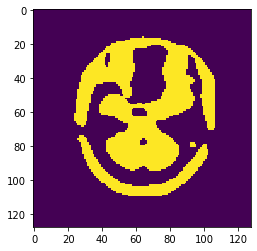

In [42]:
plt.imshow(seg_images[0])

In [44]:
# Let's also create some additional data - rotational, translational transformations

translation_images = []
rot_images = []

for i in images:
    translation_images.append(cv2.warpAffine(i, 
                                          np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]]), 
                                          (i.shape[1], i.shape[0])))
    rot_images.append(ndimage.rotate(i, random.randint(1, 359)))

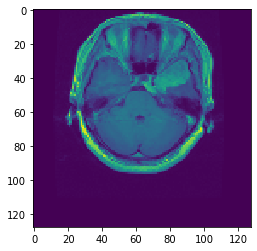

In [45]:
plt.imshow(translation_images[0])

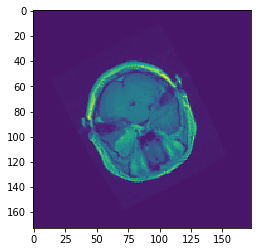

In [46]:
plt.imshow(rot_images[0])

In [56]:
# Finalize which data to use for to build and test the classifier - keep changing to see effect of different preprocessing steps

final = images.copy()
final_labels = labels.copy()

In [63]:
# Split into train and test - use 70% for training and 30% for test

train_test_split = 0.7

# Get indices of each class
ind_1 = []
ind_2 = []
ind_3 = []

for ind in range(len(final_labels)):
    if final_labels[ind] == 1:
        ind_1.append(ind)
    elif final_labels[ind] == 2:
        ind_2.append(ind)
    else:
        ind_3.append(ind)

# Get 70% for each of the classes
def get_train_test(class_list, train_test_split, final, final_labels):
    train = []
    test = []
    train_y = []
    test_y = []
    
    train_indices = random.sample(class_list, int(np.round(len(class_list)*train_test_split)))
    test_indices = list(set(class_list) - set(train_indices))
    
    for ind in range(len(final)):
        if ind in train_indices:
            train.append(final[ind])
            train_y.append(final_labels[ind])
        elif ind in test_indices:
            test.append(final[ind])
            test_y.append(final_labels[ind])
    return train, test, train_y, test_y

class_1_res = get_train_test(ind_1, train_test_split, final, final_labels)
class_2_res = get_train_test(ind_2, train_test_split, final, final_labels)
class_3_res = get_train_test(ind_3, train_test_split, final, final_labels)

train = class_1_res[0] + class_2_res[0] + class_3_res[0]
test = class_1_res[1] + class_2_res[1] + class_3_res[1]

train_y = class_1_res[2] + class_2_res[2] + class_3_res[2]
test_y = class_1_res[3] + class_2_res[3] + class_3_res[3]

# Scale train and test images from 0 to 1, reshape
for t in range(len(train)):
    temp = train[t]
    temp = temp/255
    train[t] = temp.reshape(temp.shape[0], temp.shape[1], 1)
for t in range(len(test)):
    temp = test[t]
    temp = temp/255
    test[t] = temp.reshape(temp.shape[0], temp.shape[1], 1)

In [64]:
# Quality check
print(len(train) == len(train_y))
print(len(test) == len(test_y))
print(len(train) + len(test) == len(final))

print({x: train_y.count(x) for x in set(train_y)})
print({x: test_y.count(x) for x in set(test_y)})

True
True
True
{1: 496, 2: 998, 3: 651}
{1: 212, 2: 428, 3: 279}


In [75]:
# Shuffle training data

def shuffle_lists(list1, list2):
    c = list(zip(list1, list2))
    random.shuffle(c)
    list1, list2 = zip(*c)
    return list(list1), list(list2)

train, train_y = shuffle_lists(train, train_y)
test, test_y = shuffle_lists(test, test_y)

# Convert target arrays into binary arrays
train_y = to_categorical(train_y)[:, 1:]
test_y = to_categorical(test_y)[:, 1:]

In [76]:
# Define the model

def cnn_model(n_nodes_hidden, n_hidden_layers, kernel_size = (3, 3), image_shape = (width, height, 1)):
    model = Sequential()
    model.add(layers.Conv2D(32, kernel_size, activation = 'relu', input_shape = image_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    for h in range(n_hidden_layers):
        model.add(layers.Conv2D(n_nodes_hidden, kernel_size, activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(n_nodes_hidden, kernel_size, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(n_nodes_hidden, activation='relu'))
    model.add(layers.Dense(3, activation = 'softmax'))
    
    return model, model.summary()

model, model_summary = cnn_model(64, 3)
model_summary

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 12, 12, 64)       

In [77]:
# Fit baseline model

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
fit_model = model.fit(np.array(train), train_y, epochs = 10, verbose = True)

Train on 2145 samples
Epoch 1/5
2145/2145 [==============================] - 22s 10ms/sample - loss: 0.7356 - accuracy: 0.6653
Epoch 2/5
2145/2145 [==============================] - 22s 10ms/sample - loss: 0.5393 - accuracy: 0.7510
Epoch 3/5
2145/2145 [==============================] - 23s 11ms/sample - loss: 0.4860 - accuracy: 0.7776
Epoch 4/5
2145/2145 [==============================] - 23s 11ms/sample - loss: 0.3755 - accuracy: 0.8294
Epoch 5/5
2145/2145 [==============================] - 23s 11ms/sample - loss: 0.3665 - accuracy: 0.8466


In [78]:
# Accuracy of baseline model on test data

model.evaluate(np.array(test), test_y)

919/919 [==============================] - 3s 3ms/sample - loss: 0.3376 - accuracy: 0.8466


[0.3375506286263077, 0.84657234]

In [93]:
# We want to calculate precision, recall, f1 score per class for train and test

pred_probability_train = model.predict_proba(np.array(train))
predictions_train = np.argmax(pred_probability_train, axis = 1) + 1
actuals_train = np.argmax(train_y, axis = 1) + 1

pred_probability_test = model.predict_proba(np.array(test))
predictions_test = np.argmax(pred_probability_test, axis = 1) + 1
actuals_test = np.argmax(test_y, axis = 1) + 1

for cl in [1, 2, 3]:
    print('Train & Test Precision for class ' + str(cl))
    train_precision = len([i for i,j in zip(list(predictions_train), list(actuals_train)) if i == j == cl])/len([x for x in list(predictions_train) if x == cl])
    print(train_precision)
    test_precision = len([i for i,j in zip(list(predictions_test), list(actuals_test)) if i == j == cl])/len([x for x in list(predictions_test) if x == cl])
    print(test_precision)
    
    print('Train & Test Recall for class ' + str(cl))
    train_recall = len([i for i,j in zip(list(predictions_train), list(actuals_train)) if i == j == cl])/len([x for x in list(actuals_train) if x == cl])
    print(train_recall)
    test_recall = len([i for i,j in zip(list(predictions_test), list(actuals_test)) if i == j == cl])/len([x for x in list(actuals_test) if x == cl])
    print(test_recall)
    
    print('Train & Test F1 Score for class ' + str(cl))
    train_f1 = (2*train_precision*train_recall)/(train_precision + train_recall)
    print(train_f1)
    test_f1 = (2*test_precision*test_recall)/(test_precision + test_recall)
    print(test_f1)
    print('\n')

Train & Test Precision for class 1
0.8466981132075472
0.7439024390243902
Train & Test Recall for class 1
0.7237903225806451
0.5754716981132075
Train & Test F1 Score for class 1
0.7804347826086956
0.648936170212766


Train & Test Precision for class 2
0.8813084112149533
0.8189473684210526
Train & Test Recall for class 2
0.9448897795591182
0.9088785046728972
Train & Test F1 Score for class 2
0.9119922630560929
0.8615725359911408


Train & Test Precision for class 3
0.9662058371735791
0.9535714285714286
Train & Test Recall for class 3
0.9662058371735791
0.956989247311828
Train & Test F1 Score for class 3
0.9662058371735791
0.9552772808586762




In [91]:
# Now let's automate the process and 

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)